   age           job  marital  education  balance housing  contact  day month  \
0   58    management  married   tertiary     2143     yes  unknown    5   may   
1   44    technician   single  secondary       29     yes  unknown    5   may   
2   33  entrepreneur  married  secondary        2     yes  unknown    5   may   
3   47   blue-collar  married    unknown     1506     yes  unknown    5   may   
4   33       unknown   single    unknown        1      no  unknown    5   may   

   duration  campaign  pdays  previous poutcome   y  
0       261         1     -1         0  unknown  no  
1       151         1     -1         0  unknown  no  
2        76         1     -1         0  unknown  no  
3        92         1     -1         0  unknown  no  
4       198         1     -1         0  unknown  no  

Обучающая выборка: (27126, 15)
Валидационная выборка: (9042, 15)
Тестовая выборка: (9043, 15)

Наивысший AUC имеет переменная: previous

AUC на валидационной выборке: 0.901


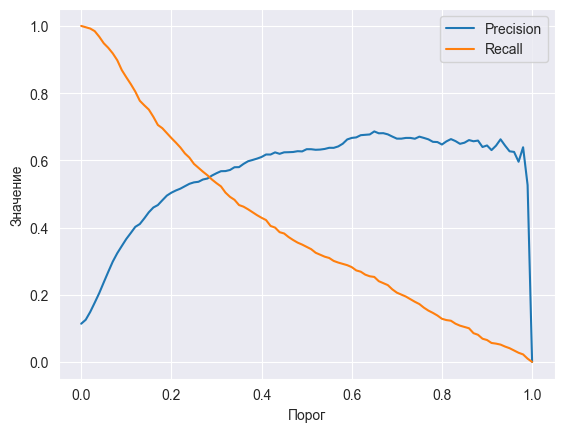

Порог пересечения Precision and Recall: 1.00

Порог, при котором F1 достигает максимума: 0.20

C=1e-06 - Значение AUC: 0.696, Стандартная ошибка: 0.008
C=0.001 - Значение AUC: 0.854, Стандартная ошибка: 0.006
C=1 - Значение AUC: 0.908, Стандартная ошибка: 0.004

Значение С, приводящее к лучшему среднему значению: 1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

# Открываем данные
df = pd.read_csv('bank-full.csv', sep=';')

selected_columns = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
df = df[selected_columns]

print(df.head())

# Разделение на обучающую, валидационную и тестовую выборки
training_set, temp_set = train_test_split(df, test_size=0.4, random_state=1)
validation_set, testing_set = train_test_split(temp_set, test_size=0.5, random_state=1)

print()
print(f"Обучающая выборка: {training_set.shape}")
print(f"Валидационная выборка: {validation_set.shape}")
print(f"Тестовая выборка: {testing_set.shape}")

# ROC AUC
nums = ['balance', 'day', 'duration', 'previous']
area_under_curve = {}

for feature in nums:
    auc = roc_auc_score(training_set['y'], training_set[feature])
    if auc < 0.5:
        auc = roc_auc_score(training_set['y'], -training_set[feature])
    area_under_curve[feature] = auc

print()
print("Наивысший AUC имеет переменная:", max(area_under_curve))

# Обучение модели
vectorizer = DictVectorizer(sparse=False)
X_training = vectorizer.fit_transform(training_set.drop(columns='y').to_dict(orient='records'))
X_validation = vectorizer.transform(validation_set.drop(columns='y').to_dict(orient='records'))

label_encoder = LabelEncoder()
y_training = label_encoder.fit_transform(training_set['y'])
y_validation = label_encoder.transform(validation_set['y'])

classifier = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
classifier.fit(X_training, y_training)

# AUC на валидационной выборке
y_predicted_proba = classifier.predict_proba(X_validation)[:, 1]
validation_auc = roc_auc_score(y_validation, y_predicted_proba)

print()
print(f"AUC на валидационной выборке: {validation_auc:.3f}")

# Точность и полнота
threshold = np.linspace(0, 1, 101)  
precision = []
recall = []

for i in threshold:
    y_predicted_threshold = (y_predicted_proba >= i).astype(int)
    precision.append(precision_score(y_validation, y_predicted_threshold, zero_division=0)) # Обработка деления на ноль
    recall.append(recall_score(y_validation, y_predicted_threshold))

plt.plot(threshold, precision, label='Precision')
plt.plot(threshold, recall, label='Recall')
plt.xlabel('Порог')
plt.ylabel('Значение')
plt.legend()
plt.show()

# Порог пересечения Precision и Recall
intersection_threshold = threshold[np.argmin(np.abs(np.array(precision) - np.array(recall)))]
print(f"Порог пересечения Precision and Recall: {intersection_threshold:.2f}")

# Порог для F1
f1_scores = [f1_score(y_validation, (y_predicted_proba >= t).astype(int)) for t in threshold]
best_f1_threshold = threshold[np.argmax(f1_scores)]
print()
print(f"Порог, при котором F1 достигает максимума: {best_f1_threshold:.2f}")
print()

# Кросс-валидация
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
C_options = [0.000001, 0.001, 1]
best_C = None
best_auc_avg = 0

for C in C_options:
    fold_aucs = []
    classifier = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    for train_indices, val_indices in kfold.split(X_training):
        X_train_fold, X_val_fold = X_training[train_indices], X_training[val_indices]
        y_train_fold, y_val_fold = y_training[train_indices], y_training[val_indices]
        
        classifier.fit(X_train_fold, y_train_fold)
        y_pred_fold = classifier.predict_proba(X_val_fold)[:, 1]
        fold_aucs.append(roc_auc_score(y_val_fold, y_pred_fold))
    
    mean_auc_fold = np.mean(fold_aucs)
    std_auc_fold = np.std(fold_aucs)
    
    print(f"C={C} - Значение AUC: {mean_auc_fold:.3f}, Стандартная ошибка: {std_auc_fold:.3f}")
    
    if mean_auc_fold > best_auc_avg:
        best_C = C
        best_auc_avg = mean_auc_fold      
print()
print(f"Значение С, приводящее к лучшему среднему значению: {best_C}")